In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os, re
from matplotlib_venn import venn2, venn3
sns.set_context('paper')

In [2]:
working_folder = "C:/Users/pc/OneDrive - UGent/run-ionbot"
data_folders = [
    "PXD002057.v0.11.4", 
    "PXD005833.v0.11.4",
    "PXD014258.v0.11.4",
]

In [3]:
project_palette = {"SwissProt":"orangered","TrEMBL":"yellowgreen","OpenProt":"cornflowerblue"}
search_labels   = {"SwissProt":"canon","TrEMBL":"trembl","OpenProt":"openprot"}

In [4]:
FILT_ORDER = ['Unfiltered','Global','GroupWalk','Custom']

In [5]:
def import_pep_IDs(PATH, filtering=False, drop_contaminants=True):
    df = pd.read_csv(PATH, usecols=['spectrum_title','scan','spectrum_file','matched_peptide','database_peptide',
                                     'modifications','leadprot','database','precursor_mass',
                                     'isCanonical','isModified',
                                     'q.value','group_qval','custom_q']
                     )

    if filtering=='global':
        df = df[df['q.value']<0.01].copy(deep=True)
    elif filtering=='groupwalk':
        df = df[df.group_qval<0.01].copy(deep=True)
    elif filtering=='custom':
        df = df[df.custom_q<0.01].copy(deep=True)
    elif filtering: 
        # gives error if filtering is not False
        print(f'Error! Filtering = {filtering}')
        return filtering

    if drop_contaminants:
        df = df[df.isCanonical!='Contam'].copy(deep=True)
    
    df['modified_peptide'] = df.matched_peptide + '|' + df.modifications
    # to remove retention times in parentheses
    df['modifications_noRT'] = df.modifications.str.replace(re.compile(r'\(.+?\)'), '', regex=True)
    
    return df

In [6]:
def plot_psms_counts(working_folder_, dataset_name_):
    file_path = os.path.join(working_folder_, dataset_name_, f"{dataset_name}-openprot", "combo-group-walk-output.csv")
    unfiltered         = import_pep_IDs(file_path)
    global_filtered    = import_pep_IDs(file_path, filtering='global')
    groupwalk_filtered = import_pep_IDs(file_path, filtering='groupwalk')
    custom_filtered    = import_pep_IDs(file_path, filtering='custom')
    
    unfiltered['filter'] = 'Unfiltered'
    global_filtered['filter'] = 'Global'
    groupwalk_filtered['filter'] = 'GroupWalk'
    custom_filtered['filter'] = 'Custom'
    
    data2 = pd.concat([
        unfiltered.groupby(['filter','isCanonical','isModified',])[['spectrum_title']].count().reset_index(), 
        global_filtered.groupby(['filter','isCanonical','isModified',])[['spectrum_title']].count().reset_index(), 
        groupwalk_filtered.groupby(['filter','isCanonical','isModified',])[['spectrum_title']].count().reset_index(),
        custom_filtered.groupby(['filter','isCanonical','isModified',])[['spectrum_title']].count().reset_index()
        ], ignore_index=True)
    
    # data2 = data.groupby(['filter','isCanonical','isModified',])[['spectrum_title']].count().reset_index()
    
    ax = sns.lineplot(data=data2, y='spectrum_title', x='filter', style='isCanonical', hue='isModified', markers=True)
    plt.title(f"{dataset_name}")
    plt.ylabel('#PSMs')
    plt.yscale('log')
    # plt.ylim(80, 1)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

def plot_psms_counts_2(working_folder_, dataset_name_, ax_):
    file_path = os.path.join(working_folder_, dataset_name_, f"{dataset_name}-openprot", "combo-group-walk-output.csv")
    unfiltered         = import_pep_IDs(file_path)
    global_filtered    = import_pep_IDs(file_path, filtering='global')
    groupwalk_filtered = import_pep_IDs(file_path, filtering='groupwalk')
    custom_filtered    = import_pep_IDs(file_path, filtering='custom')
    
    unfiltered['filter'] = 'Unfiltered'
    global_filtered['filter'] = 'Global'
    groupwalk_filtered['filter'] = 'GroupWalk'
    custom_filtered['filter'] = 'Custom'
    
    data2 = pd.concat([
        unfiltered.groupby(['filter','isCanonical','isModified',])[['spectrum_title']].count().reset_index(), 
        global_filtered.groupby(['filter','isCanonical','isModified',])[['spectrum_title']].count().reset_index(), 
        groupwalk_filtered.groupby(['filter','isCanonical','isModified',])[['spectrum_title']].count().reset_index(),
        custom_filtered.groupby(['filter','isCanonical','isModified',])[['spectrum_title']].count().reset_index()
        ], ignore_index=True)
    
    # data2 = data.groupby(['filter','isCanonical','isModified',])[['spectrum_title']].count().reset_index()
    
    g = sns.lineplot(data=data2, y='spectrum_title', x='filter', style='isCanonical', hue='isModified', markers=True, ax=ax_)
    g.set_title(f"{dataset_name.split('.')[0]}, OpenProt search")
    g.set_ylabel('#PSMs')
    g.set_yscale('log')

In [7]:
def compare_filtering_FDR(working_folder_, dataset_name_):
    unfiltered         = pd.read_csv(os.path.join(working_folder_, dataset_name_, "ID-rate-df-filt-False.csv"))
    global_filtered    = pd.read_csv(os.path.join(working_folder_, dataset_name_, "ID-rate-df-filt-global.csv"))
    groupwalk_filtered = pd.read_csv(os.path.join(working_folder_, dataset_name_, "ID-rate-df-filt-groupwalk.csv"))
    custom_filtered    = pd.read_csv(os.path.join(working_folder_, dataset_name_, "ID-rate-df-filt-custom.csv"))
    
    unfiltered['filter'] = 'Unfiltered'
    global_filtered['filter'] = 'Global'
    groupwalk_filtered['filter'] = 'GroupWalk'
    custom_filtered['filter'] = 'Custom'
    
    data = pd.concat([unfiltered, global_filtered, groupwalk_filtered, custom_filtered], ignore_index=True)
    
    sns.catplot(data=data, x='search', y='ID_rate', hue='filter', dodge=True, 
                edgecolor='k', linewidth=1, hue_order=FILT_ORDER)
    sns.boxplot(data=data, x='search', y='ID_rate', hue='filter', 
                dodge=True, palette='pastel', legend=False, hue_order=FILT_ORDER)
    # sns.catplot(data=data, x='search', y='ID_rate', hue='filter', kind='violin')
    # plt.ylim(0,1)
    plt.title(dataset_name_)
    plt.show()\

def compare_filtering_FDR_2(working_folder_, dataset_name_):
    unfiltered         = pd.read_csv(os.path.join(working_folder_, dataset_name_, "ID-rate-df-filt-False.csv"))
    global_filtered    = pd.read_csv(os.path.join(working_folder_, dataset_name_, "ID-rate-df-filt-global.csv"))
    groupwalk_filtered = pd.read_csv(os.path.join(working_folder_, dataset_name_, "ID-rate-df-filt-groupwalk.csv"))
    custom_filtered    = pd.read_csv(os.path.join(working_folder_, dataset_name_, "ID-rate-df-filt-custom.csv"))
    
    unfiltered['Filter'] = 'Unfiltered'
    global_filtered['Filter'] = 'Global'
    groupwalk_filtered['Filter'] = 'GroupWalk'
    custom_filtered['Filter'] = 'Custom'
    
    data = pd.concat([unfiltered, global_filtered, groupwalk_filtered, custom_filtered], ignore_index=True)
    data['PXD'] = dataset_name_
    return data

In [8]:
def get_FDR_df(PATH, filtering=False):
    data3 = pd.read_csv(PATH, low_memory=False)
    
    if filtering=='global':
        data3 = data3[data3['q.value']<.01].copy(deep=True)
    elif filtering=='groupwalk':
        data3 = data3[data3.group_qval<.01].copy(deep=True)
    elif filtering=='custom':
        data3 = data3[data3.custom_q<0.01].copy(deep=True)
    elif filtering: 
        # gives error if filtering is not False
        print(f'Error! Filtering = {filtering}')
        return filtering

    FDR_df = []
    for (c,m),df in data3.groupby(['isCanonical','isModified']).__iter__():
        if c=='Contam':
            continue
        tmp = df.database.value_counts()
        try:
            fdr = tmp['D']/tmp['T']
            # fdr = (2*tmp['D'])/(tmp['D']+tmp['T'])
        except:
            fdr = 0
            tmp['D'] = 0
        if fdr > 0:
            FDR_df.append([c,m,fdr])
    return pd.DataFrame(FDR_df, columns=['isCanonical','isModified','FDR'])

def plot_FDR_levels(working_folder_, dataset_name_):
    file_path = os.path.join(working_folder_, dataset_name_, f"{dataset_name_}-openprot", "combo-group-walk-output.csv")
    unfiltered         = get_FDR_df(file_path)
    global_filtered    = get_FDR_df(file_path, filtering='global')
    groupwalk_filtered = get_FDR_df(file_path, filtering='groupwalk')
    custom_filtered    = get_FDR_df(file_path, filtering='custom')

    unfiltered['filter'] = 'Unfiltered'
    global_filtered['filter'] = 'Global'
    groupwalk_filtered['filter'] = 'GroupWalk'
    custom_filtered['filter'] = 'Custom'

    data = pd.concat([unfiltered, global_filtered, groupwalk_filtered, custom_filtered], ignore_index=True)
    
    ax = sns.lineplot(data=data, y='FDR', x='filter', style='isCanonical', hue='isModified', 
                      markers=True, palette='pastel', 
                      # order=FILT_ORDER
                     )
    plt.title(f"{dataset_name.split('.')[0]}, OpenProt search")
    plt.ylabel('FDR level')
    plt.yscale('log')
    plt.ylim(0.001, 1)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

def plot_FDR_levels_2(working_folder_, dataset_name_, ax_):
    file_path = os.path.join(working_folder_, dataset_name_, f"{dataset_name_}-openprot", "combo-group-walk-output.csv")
    unfiltered         = get_FDR_df(file_path)
    global_filtered    = get_FDR_df(file_path, filtering='global')
    groupwalk_filtered = get_FDR_df(file_path, filtering='groupwalk')
    custom_filtered    = get_FDR_df(file_path, filtering='custom')

    unfiltered['filter'] = 'Unfiltered'
    global_filtered['filter'] = 'Global'
    groupwalk_filtered['filter'] = 'GroupWalk'
    custom_filtered['filter'] = 'Custom'

    data = pd.concat([unfiltered, global_filtered, groupwalk_filtered, custom_filtered], ignore_index=True)
    
    g = sns.lineplot(data=data, y='FDR', x='filter', style='isCanonical', hue='isModified', 
                      markers=True, palette='pastel', 
                      # order=FILT_ORDER
                      ax=ax_
                     )
    g.set_title(f"{dataset_name.split('.')[0]}, OpenProt search")
    g.set_ylabel('FDR level')
    g.set_yscale('log')

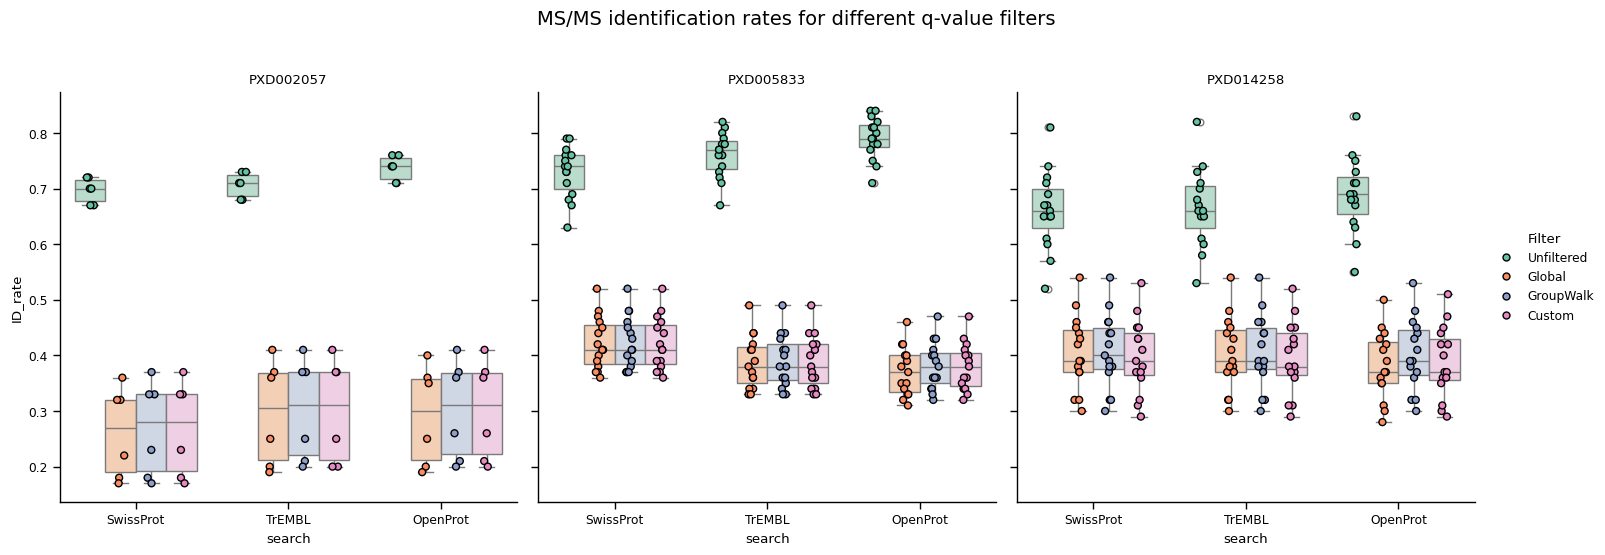

In [9]:
tmp = [compare_filtering_FDR_2(working_folder, dataset_name) for dataset_name in data_folders]
tmp = pd.concat(tmp, ignore_index=True)
G = sns.catplot(data=tmp, x='search', y='ID_rate', hue='Filter', dodge=True, edgecolor='k', linewidth=1, hue_order=FILT_ORDER, col='PXD',
               palette='Set2')
G.fig.suptitle(f"MS/MS identification rates for different q-value filters", size=14, y=1.1)
for ax in G.axes[0]:
    t = ax.title.get_text()
    t = t.split()[2]
    sns.boxplot(data=tmp[tmp.PXD==t], x='search', y='ID_rate', hue='Filter', 
                dodge=True, palette='Pastel2', legend=False, hue_order=FILT_ORDER, ax=ax)
    t = t.split('.')[0]
    ax.set_title(t)
plt.savefig('C:/Users/pc/OneDrive - UGent/OpenProt_2/oui-discovery/publication-data/ID-rates-1.svg', dpi=300, bbox_inches='tight')

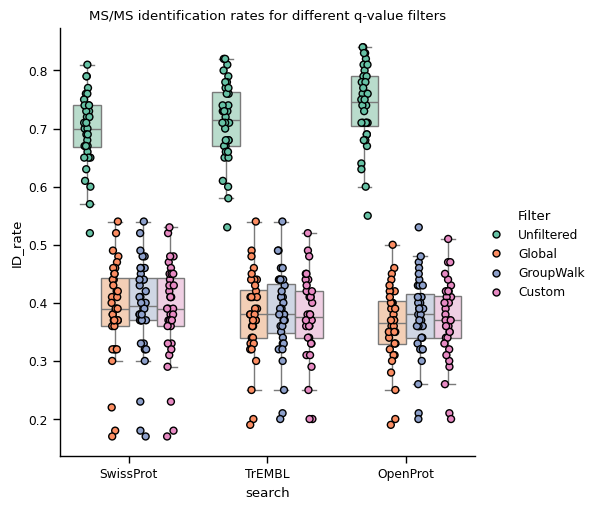

In [10]:
tmp = [compare_filtering_FDR_2(working_folder, dataset_name) for dataset_name in data_folders]
tmp = pd.concat(tmp, ignore_index=True)

sns.catplot(data=tmp, x='search', y='ID_rate', hue='Filter', dodge=True, edgecolor='k', 
            linewidth=1, hue_order=FILT_ORDER, 
            palette='Set2')
sns.boxplot(data=tmp, x='search', y='ID_rate', hue='Filter', 
            dodge=True, palette='Pastel2', legend=False, showfliers=False, hue_order=FILT_ORDER)
plt.title(f"MS/MS identification rates for different q-value filters")
plt.savefig('C:/Users/pc/OneDrive - UGent/OpenProt_2/oui-discovery/publication-data/ID-rates-2.svg', dpi=300, bbox_inches='tight')

In [11]:
# for dataset_name in ["PXD002057.v0.11.4", "PXD005833.v0.11.4", "PXD014258.v0.11.4"]:
#     compare_filtering_FDR(working_folder, dataset_name)

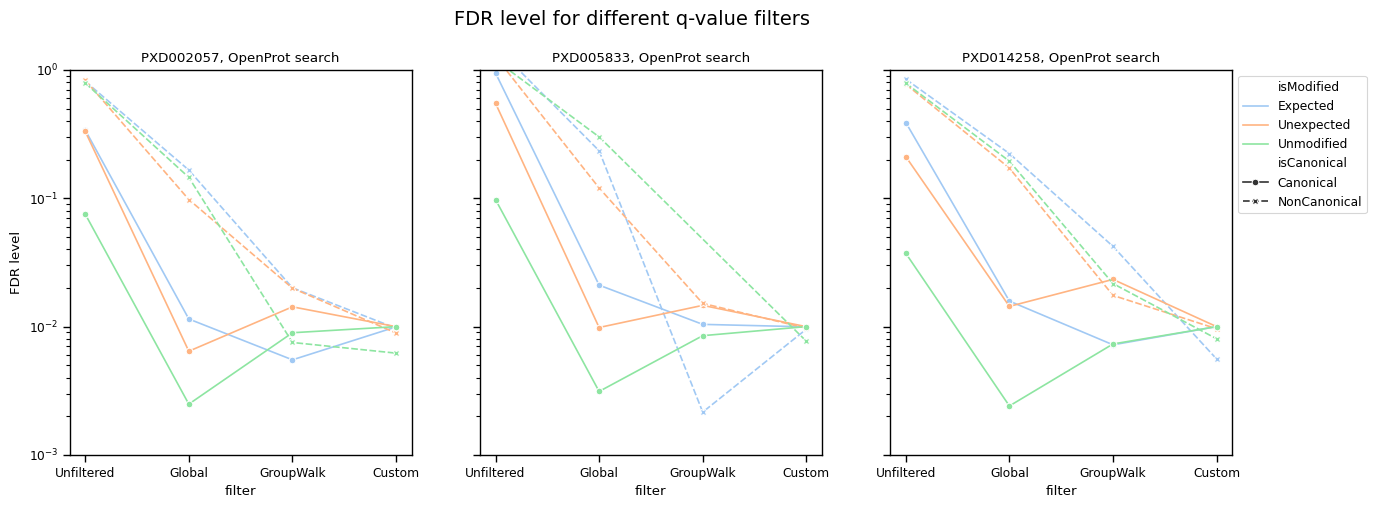

In [12]:
fig,axes = plt.subplots(1,3,sharey=True, figsize=(15,5))
fig.suptitle(f"FDR level for different q-value filters", size=14, y=1)
for dataset_name,ax in zip(data_folders,axes):
    plot_FDR_levels_2(working_folder, dataset_name, ax)
for _ in axes:
    _.set_ylim(0.001, 1)
axes[0].legend_.remove()
axes[1].legend_.remove()
sns.move_legend(axes[2], "upper left", bbox_to_anchor=(1, 1))
plt.savefig('C:/Users/pc/OneDrive - UGent/OpenProt_2/oui-discovery/publication-data/FDR-levels.svg', dpi=300, bbox_inches='tight')

In [13]:
# for dataset_name in ["PXD002057.v0.11.4", "PXD005833.v0.11.4", "PXD014258.v0.11.4"]:
#     plot_FDR_levels(working_folder, dataset_name)
# global FDR filtering overestimates FDR for canonical peptides but underestimates the one for noncanonical

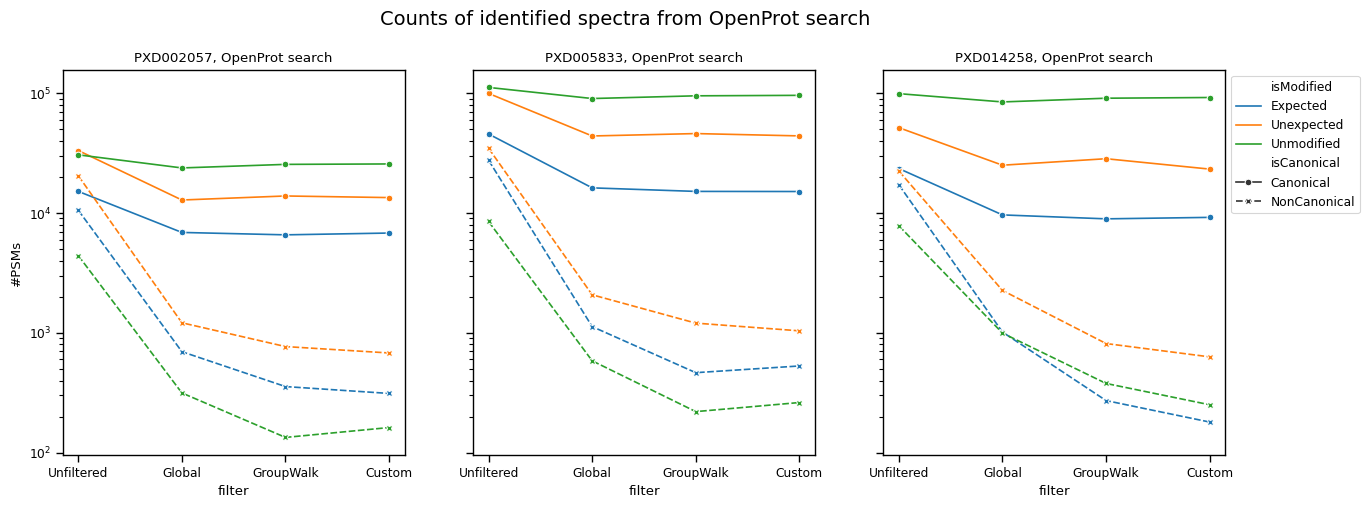

In [14]:
fig,axes = plt.subplots(1,3,sharey=True, figsize=(15,5))
fig.suptitle(f"Counts of identified spectra from OpenProt search", size=14, y=1)
for dataset_name,ax in zip(data_folders,axes):
    plot_psms_counts_2(working_folder, dataset_name, ax)
axes[0].legend_.remove()
axes[1].legend_.remove()
sns.move_legend(axes[2], "upper left", bbox_to_anchor=(1, 1))
plt.savefig('C:/Users/pc/OneDrive - UGent/OpenProt_2/oui-discovery/publication-data/PSM-counts.svg', dpi=300, bbox_inches='tight')

In [15]:
# for dataset_name in ["PXD002057.v0.11.4", "PXD005833.v0.11.4", "PXD014258.v0.11.4"]:
#     plot_psms_counts(working_folder, dataset_name)

----

In [16]:
legend_title = "Search Database"
p = [mpatches.Patch(color=c, label=l, alpha=0.7) for l,c in project_palette.items()] 

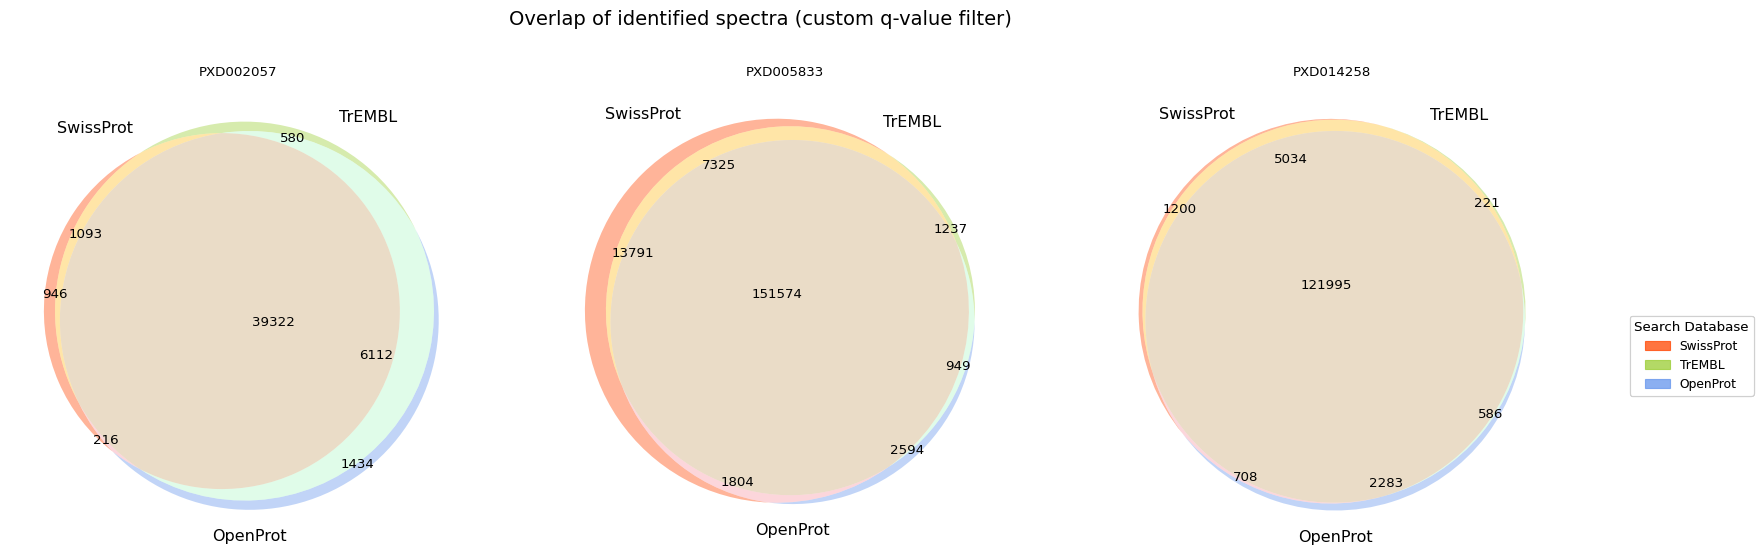

In [17]:
fig, ax = plt.subplots(1, 3, sharey=True,sharex=True, figsize=(20,10))
fig.suptitle(f"Overlap of identified spectra (custom q-value filter)", size=14, y=0.8)
for i,dataset_name in enumerate(data_folders):
    param = 'spectrum_title'
    spectra_sets = {search:{} for search in search_labels.keys()}
    for x in spectra_sets.keys():
        search = search_labels[x]
        file_path = os.path.join(working_folder, dataset_name, f"{dataset_name}-{search}", "combo-group-walk-output.csv")
        spectra_sets[x] = set(import_pep_IDs(file_path, filtering='custom')[param])
    venn3([spectra_sets[_] for _ in project_palette.keys()], 
          set_labels=project_palette.keys(), 
          set_colors=project_palette.values(),
          ax=ax[i])
    ax[i].set_title(f"{dataset_name.split('.')[0]}")
    fig.legend(handles=p, title=legend_title, loc='upper right', bbox_to_anchor=(1, 0.5))
plt.savefig('C:/Users/pc/OneDrive - UGent/OpenProt_2/oui-discovery/publication-data/custom-q-psm-overlap.svg', dpi=300, bbox_inches='tight')

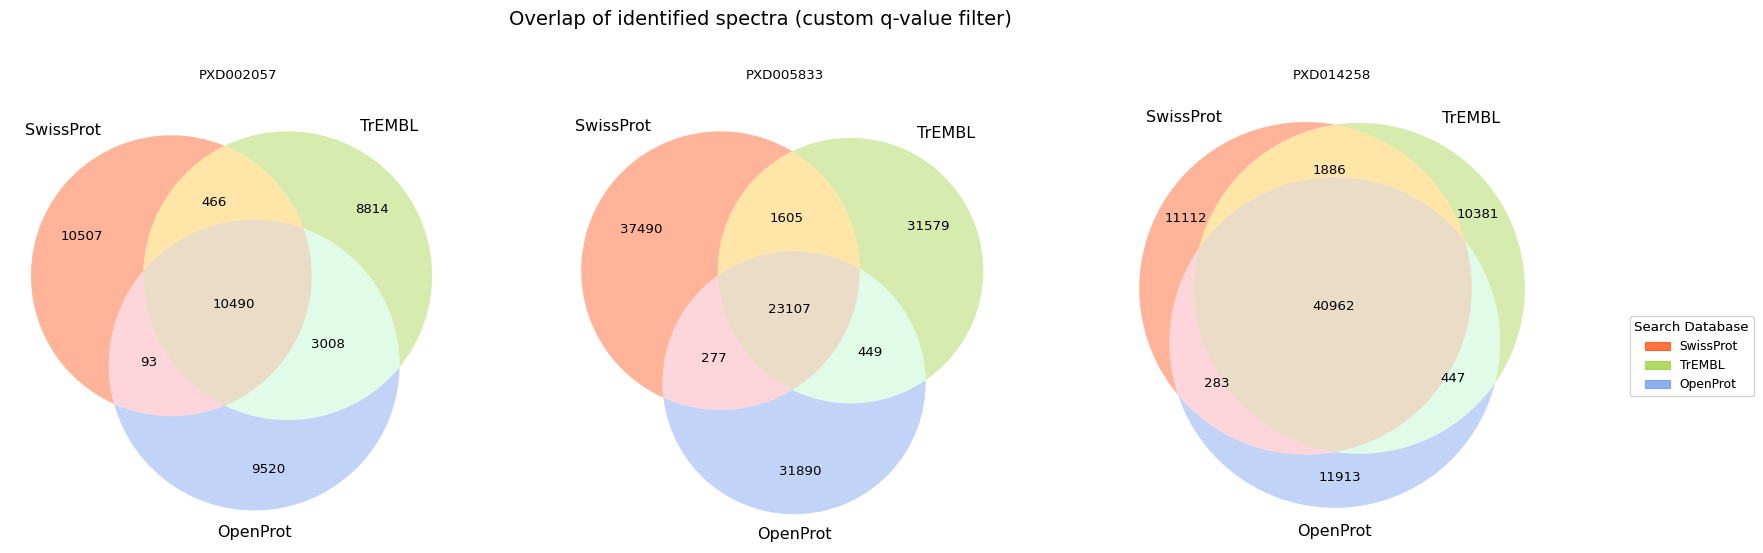

In [18]:
fig, ax = plt.subplots(1, 3, sharey=True,sharex=True, figsize=(20,10))
fig.suptitle(f"Overlap of identified spectra (custom q-value filter)", size=14, y=0.8)
for i,dataset_name in enumerate(data_folders):
    param = 'modified_peptide'
    spectra_sets = {search:{} for search in search_labels.keys()}
    for x in spectra_sets.keys():
        search = search_labels[x]
        file_path = os.path.join(working_folder, dataset_name, f"{dataset_name}-{search}", "combo-group-walk-output.csv")
        spectra_sets[x] = set(import_pep_IDs(file_path, filtering='custom')[param])
    venn3([spectra_sets[_] for _ in project_palette.keys()], 
          set_labels=project_palette.keys(), 
          set_colors=project_palette.values(),
          ax=ax[i])
    ax[i].set_title(f"{dataset_name.split('.')[0]}")
    fig.legend(handles=p, title=legend_title, loc='upper right', bbox_to_anchor=(1, 0.5))
plt.savefig('C:/Users/pc/OneDrive - UGent/OpenProt_2/oui-discovery/publication-data/custom-q-peptidoform-overlap.svg', dpi=300, bbox_inches='tight')

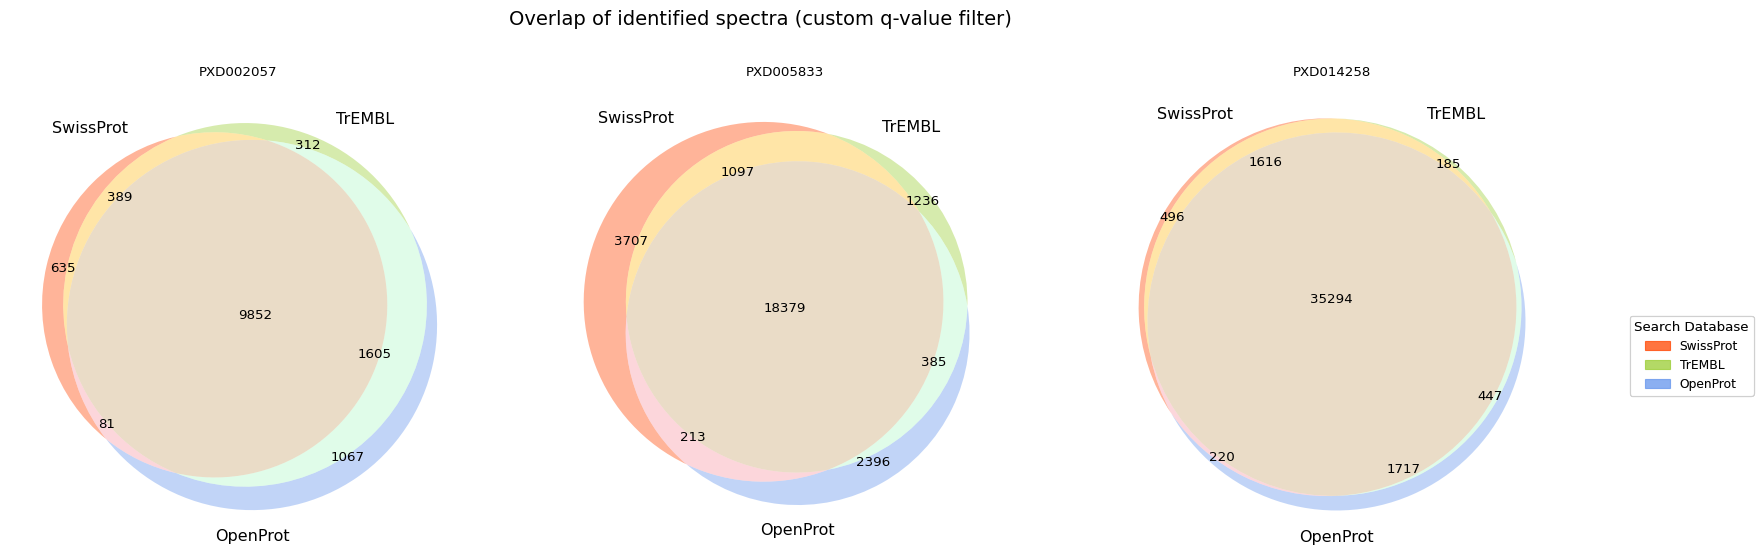

In [19]:
fig, ax = plt.subplots(1, 3, sharey=True,sharex=True, figsize=(20,10))
fig.suptitle(f"Overlap of identified spectra (custom q-value filter)", size=14, y=0.8)
for i,dataset_name in enumerate(data_folders):
    param = 'matched_peptide'
    spectra_sets = {search:{} for search in search_labels.keys()}
    for x in spectra_sets.keys():
        search = search_labels[x]
        file_path = os.path.join(working_folder, dataset_name, f"{dataset_name}-{search}", "combo-group-walk-output.csv")
        spectra_sets[x] = set(import_pep_IDs(file_path, filtering='custom')[param])
    venn3([spectra_sets[_] for _ in project_palette.keys()], 
          set_labels=project_palette.keys(), 
          set_colors=project_palette.values(),
          ax=ax[i])
    ax[i].set_title(f"{dataset_name.split('.')[0]}")
    fig.legend(handles=p, title=legend_title, loc='upper right', bbox_to_anchor=(1, 0.5))
plt.savefig('C:/Users/pc/OneDrive - UGent/OpenProt_2/oui-discovery/publication-data/custom-q-peptide-overlap.svg', dpi=300, bbox_inches='tight')

----

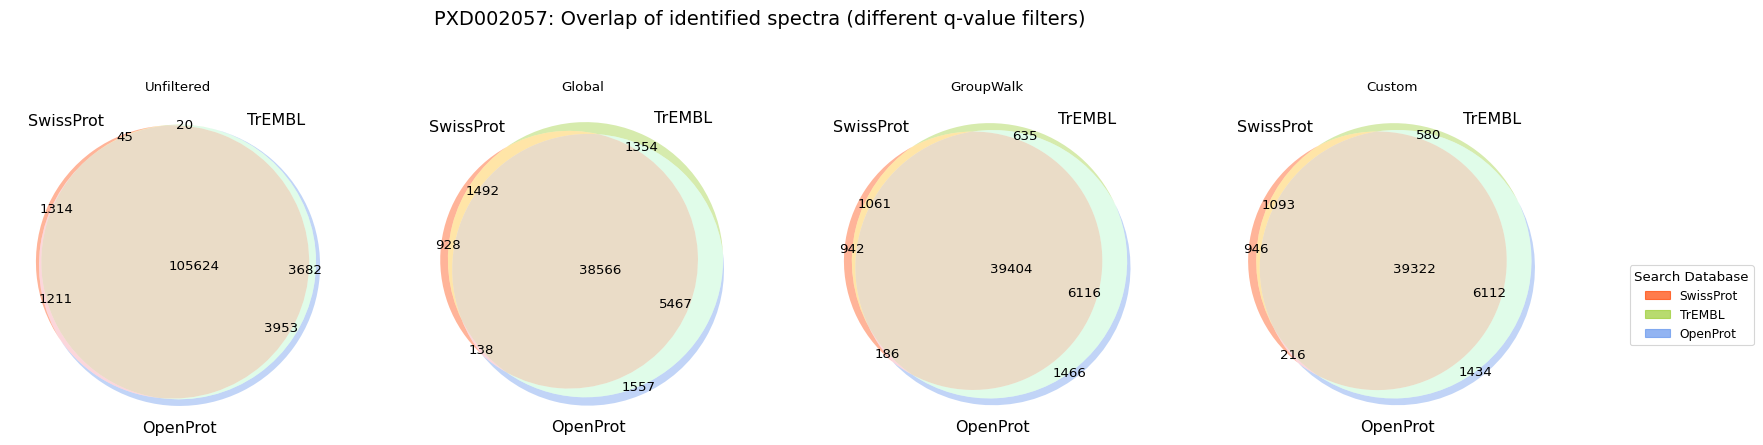

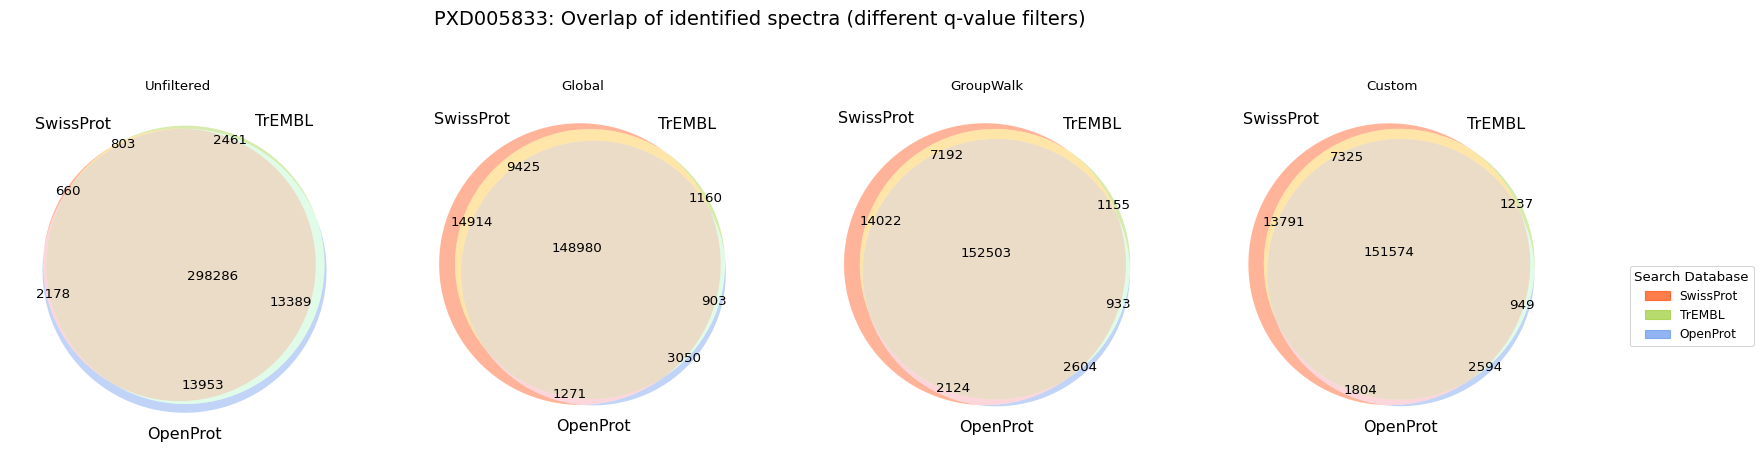

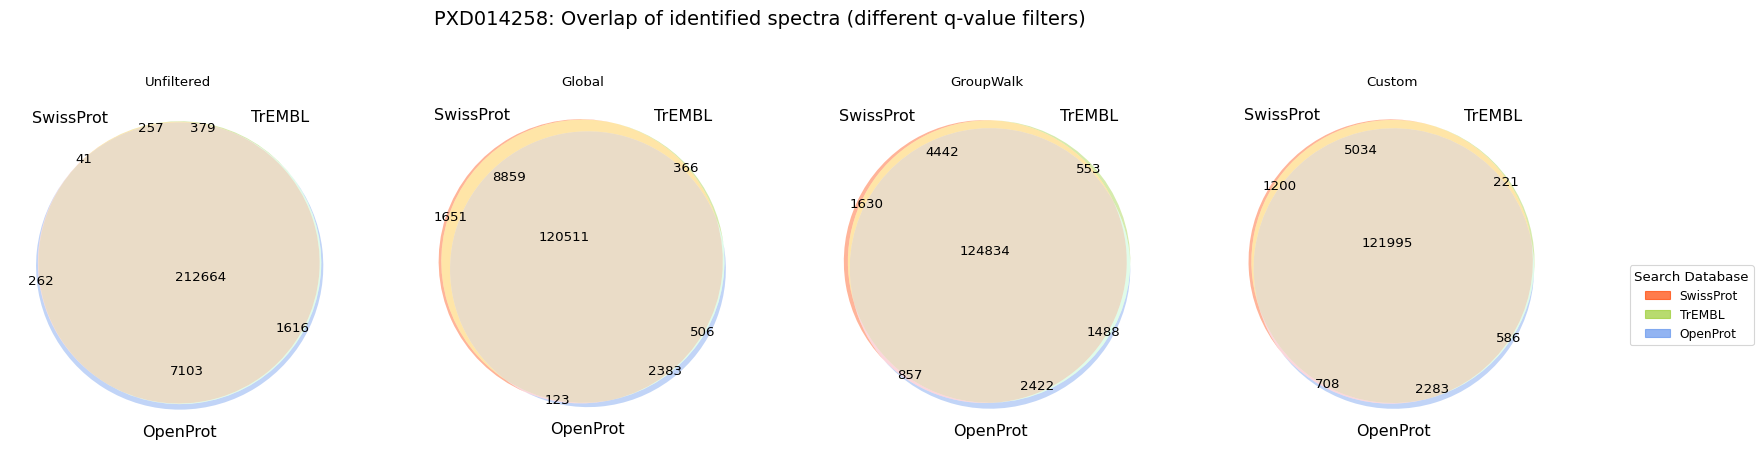

In [20]:
for dataset_name in ["PXD002057.v0.11.4", "PXD005833.v0.11.4", "PXD014258.v0.11.4"]:
    param = 'spectrum_title'
    # make the df
    tmp = []
    for search in ['canon','trembl','openprot']:
        file_path = os.path.join(working_folder, dataset_name, f"{dataset_name}-{search}", "combo-group-walk-output.csv")
        unfiltered         = import_pep_IDs(file_path)
        global_filtered    = import_pep_IDs(file_path, filtering='global')
        groupwalk_filtered = import_pep_IDs(file_path, filtering='groupwalk')
        custom_filtered    = import_pep_IDs(file_path, filtering='custom')
        
        unfiltered['filter'] = 'Unfiltered'
        global_filtered['filter'] = 'Global'
        groupwalk_filtered['filter'] = 'GroupWalk'
        custom_filtered['filter'] = 'Custom'
        
        data = pd.concat([unfiltered, global_filtered, groupwalk_filtered, custom_filtered], ignore_index=True)
        # data = data[['matched_peptide','modifications','filter']].copy(deep=True)
        data = data[['spectrum_title','matched_peptide','database_peptide','modifications','filter','database']].copy(deep=True)
        data['peptidoform'] = data.matched_peptide + '|' + data.modifications
        data.drop_duplicates(inplace=True)
        data['search'] = search
        tmp.append(data)
        del data
    tmp = pd.concat(tmp, ignore_index=True)

    # make the plots
    fig, ax = plt.subplots(1, 4, sharey=True,sharex=True, figsize=(20,10))
    fig.suptitle(f"{dataset_name.split('.')[0]}: Overlap of identified spectra (different q-value filters)",size=14, y=0.75)
    for i,filt in enumerate(FILT_ORDER):
        spectra_sets = {_:{} for _ in set(tmp['filter'])}
        
        for (f,s),df in tmp.groupby(['filter','search']).__iter__():
            spectra_sets[f][s] = set(df[param])
        
        venn3([spectra_sets[filt][search_labels[_]] for _ in project_palette.keys()], 
              set_labels=project_palette.keys(), 
              set_colors=project_palette.values(),
             ax=ax[i])
        ax[i].set_title(f"{filt}")
    fig.legend(handles=p, title=legend_title, loc='upper right', bbox_to_anchor=(1, 0.5))
    print('\n')
    path_ = f'C:/Users/pc/OneDrive - UGent/OpenProt_2/oui-discovery/publication-data/all-filters-psm-overlap-{dataset_name.split('.')[0]}.svg'
    plt.savefig(path_, dpi=300, bbox_inches='tight')

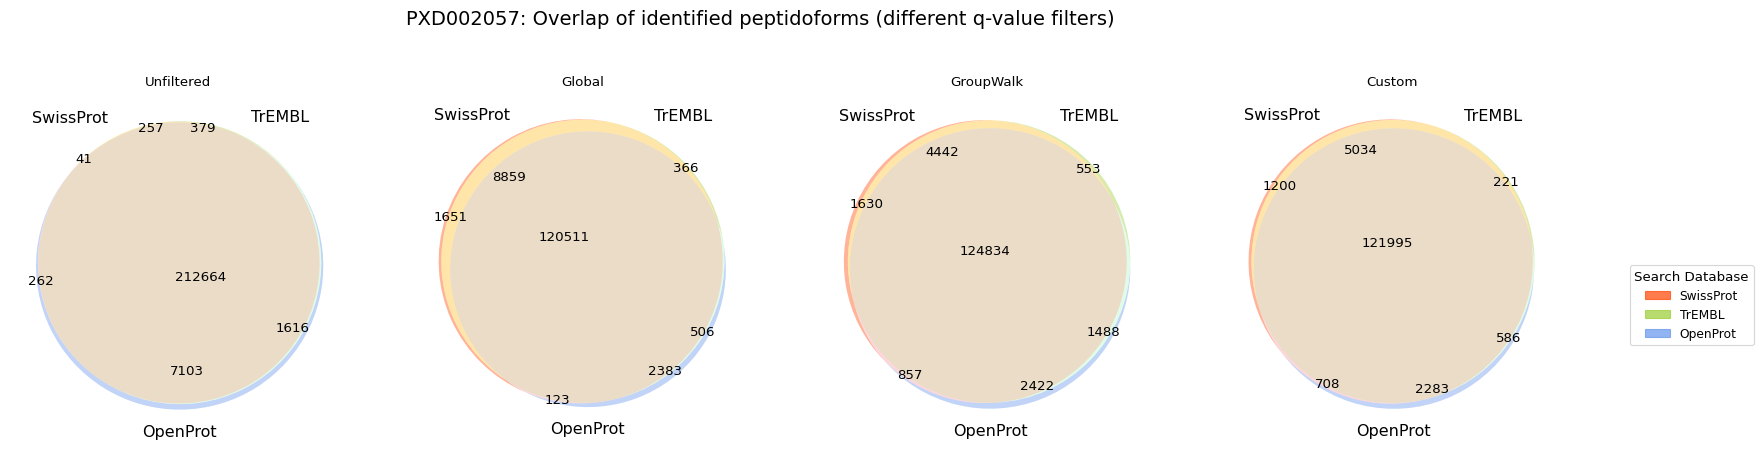

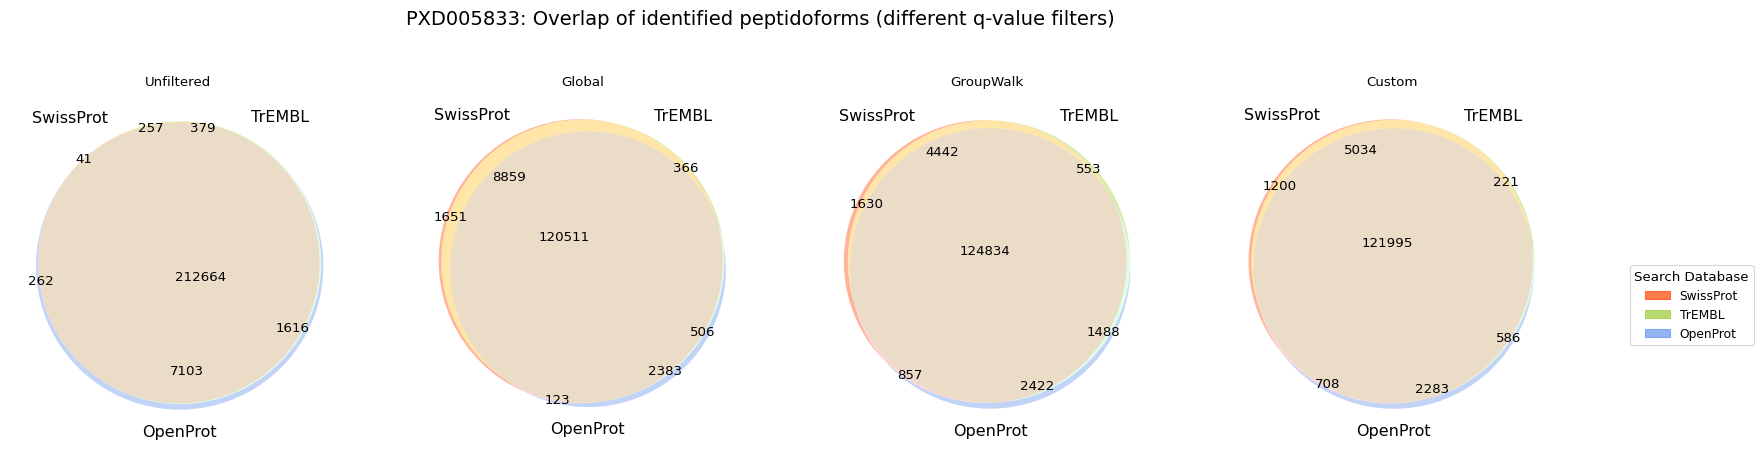

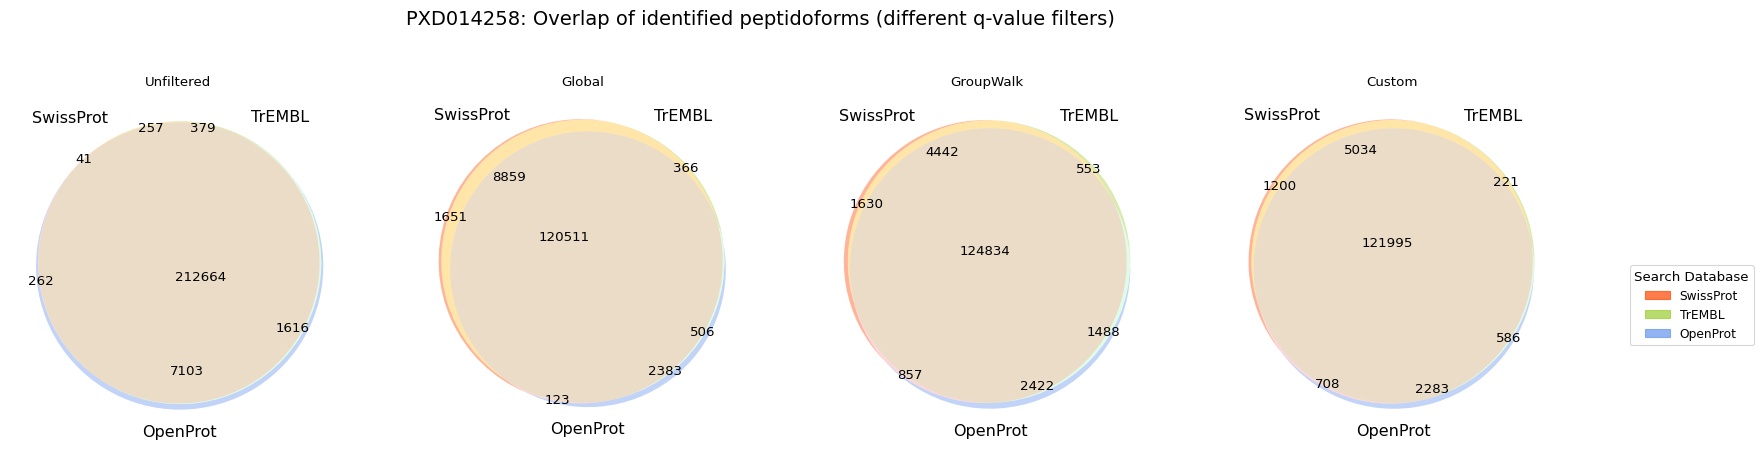

In [21]:
for dataset_name in ["PXD002057.v0.11.4", "PXD005833.v0.11.4", "PXD014258.v0.11.4"]:
    param = 'modified_peptide'
    # make the df
    tmp = []
    for search in ['canon','trembl','openprot']:
        file_path = os.path.join(working_folder, dataset_name, f"{dataset_name}-{search}", "combo-group-walk-peptidoforms-output.csv")
        unfiltered         = import_pep_IDs(file_path)
        global_filtered    = import_pep_IDs(file_path, filtering='global')
        groupwalk_filtered = import_pep_IDs(file_path, filtering='groupwalk')
        custom_filtered    = import_pep_IDs(file_path, filtering='custom')
        
        unfiltered['filter'] = 'Unfiltered'
        global_filtered['filter'] = 'Global'
        groupwalk_filtered['filter'] = 'GroupWalk'
        custom_filtered['filter'] = 'Custom'
        
        data = pd.concat([unfiltered, global_filtered, groupwalk_filtered, custom_filtered], ignore_index=True)
        # data = data[['matched_peptide','modifications','filter']].copy(deep=True)
        data = data[['spectrum_title','matched_peptide','modified_peptide','database_peptide','modifications','filter','database']].copy(deep=True)
        data['peptidoform'] = data.matched_peptide + '|' + data.modifications
        data.drop_duplicates(inplace=True)
        data['search'] = search
        tmp.append(data)
        del data
    tmp = pd.concat(tmp, ignore_index=True)

    # make the plots
    fig, ax = plt.subplots(1, 4, sharey=True,sharex=True, figsize=(20,10))
    fig.suptitle(f"{dataset_name.split('.')[0]}: Overlap of identified peptidoforms (different q-value filters)",size=14, y=0.75);
    for i,filt in enumerate(FILT_ORDER):
        pep_sets = {_:{} for _ in set(tmp['filter'])}
        
        for (f,s,d),df in tmp.groupby(['filter','search','database']).__iter__():
            if d=='T':
                pep_sets[f][s] = set(df[param])
        
        venn3([spectra_sets[filt][search_labels[_]] for _ in project_palette.keys()], 
              set_labels=project_palette.keys(), 
              set_colors=project_palette.values(),
             ax=ax[i])
        ax[i].set_title(f"{filt}")
    fig.legend(handles=p, title=legend_title, loc='upper right', bbox_to_anchor=(1, 0.5))
    print('\n')
    path_ = f'C:/Users/pc/OneDrive - UGent/OpenProt_2/oui-discovery/publication-data/all-filters-peptidoforms-overlap-{dataset_name.split('.')[0]}.svg'
    plt.savefig(path_, dpi=300, bbox_inches='tight')

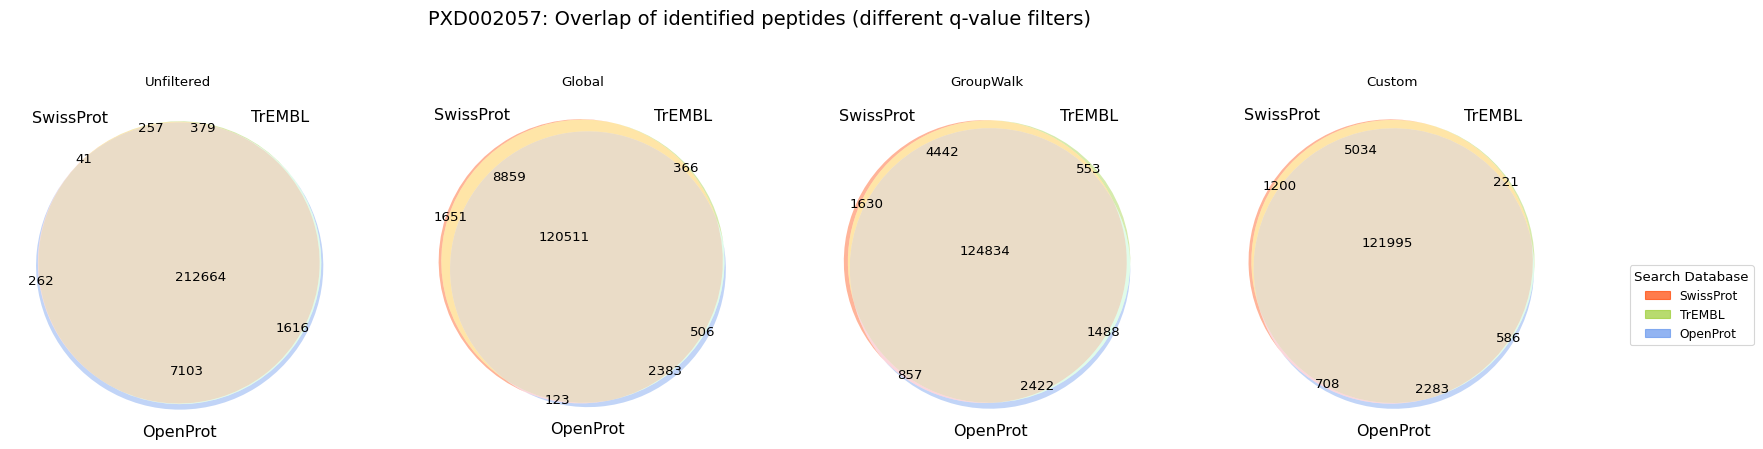

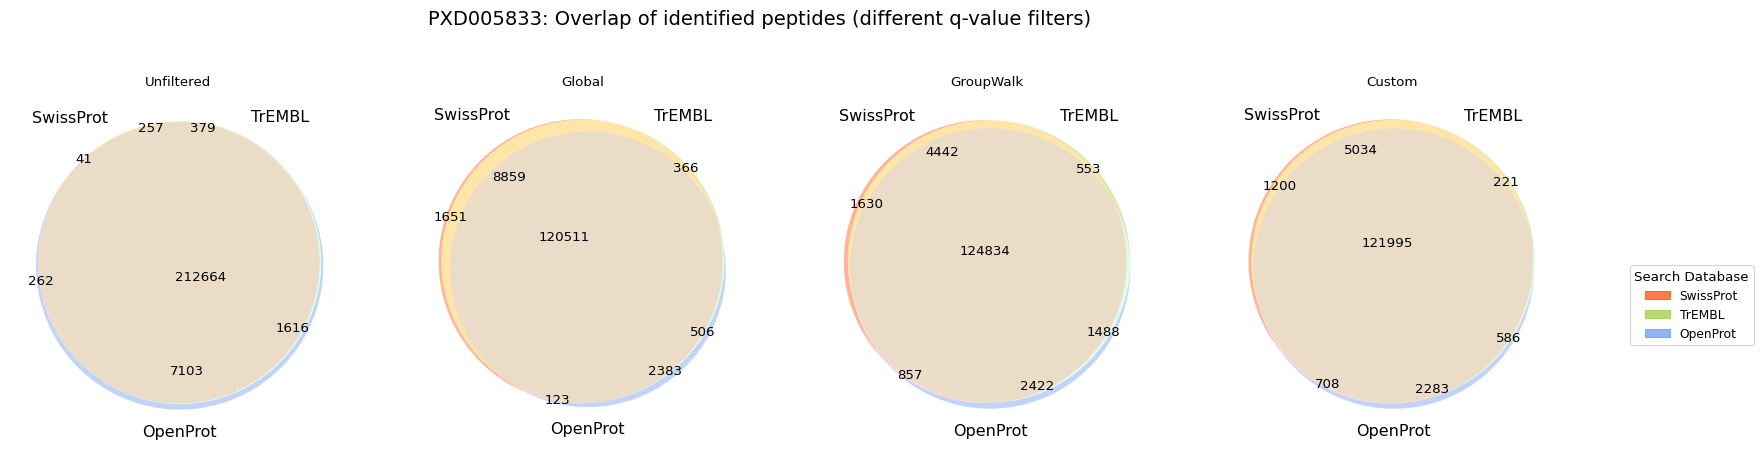

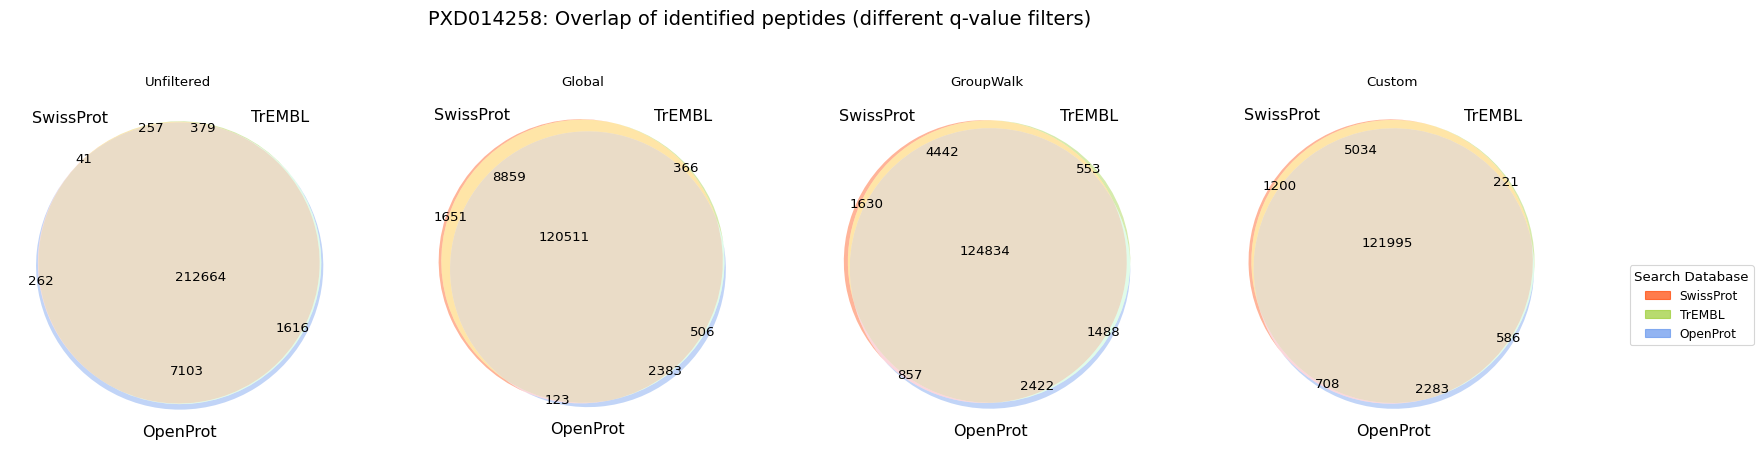

In [22]:
for dataset_name in ["PXD002057.v0.11.4", "PXD005833.v0.11.4", "PXD014258.v0.11.4"]:
    param = 'matched_peptide'
    # make the df
    tmp = []
    for search in ['canon','trembl','openprot']:
        file_path = os.path.join(working_folder, dataset_name, f"{dataset_name}-{search}", "combo-group-walk-peptides-output.csv")
        unfiltered         = import_pep_IDs(file_path)
        global_filtered    = import_pep_IDs(file_path, filtering='global')
        groupwalk_filtered = import_pep_IDs(file_path, filtering='groupwalk')
        custom_filtered    = import_pep_IDs(file_path, filtering='custom')
        
        unfiltered['filter'] = 'Unfiltered'
        global_filtered['filter'] = 'Global'
        groupwalk_filtered['filter'] = 'GroupWalk'
        custom_filtered['filter'] = 'Custom'
        
        data = pd.concat([unfiltered, global_filtered, groupwalk_filtered, custom_filtered], ignore_index=True)
        # data = data[['matched_peptide','modifications','filter']].copy(deep=True)
        data = data[['spectrum_title','matched_peptide','database_peptide','modifications','filter','database']].copy(deep=True)
        data['peptidoform'] = data.matched_peptide + '|' + data.modifications
        data.drop_duplicates(inplace=True)
        data['search'] = search
        tmp.append(data)
        del data
    tmp = pd.concat(tmp, ignore_index=True)

    # make the plots
    fig, ax = plt.subplots(1, 4, sharey=True,sharex=True, figsize=(20,10))
    fig.suptitle(f"{dataset_name.split('.')[0]}: Overlap of identified peptides (different q-value filters)",size=14, y=0.75);
    for i,filt in enumerate(FILT_ORDER):
        pep_sets = {_:{} for _ in set(tmp['filter'])}
        
        for (f,s,d),df in tmp.groupby(['filter','search','database']).__iter__():
            if d=='T':
                pep_sets[f][s] = set(df[param])
        
        venn3([spectra_sets[filt][search_labels[_]] for _ in project_palette.keys()], 
              set_labels=project_palette.keys(), 
              set_colors=project_palette.values(),
             ax=ax[i])
        ax[i].set_title(f"{filt}")
    fig.legend(handles=p, title=legend_title, loc='upper right', bbox_to_anchor=(1, 0.5))
    print('\n')
    path_ = f'C:/Users/pc/OneDrive - UGent/OpenProt_2/oui-discovery/publication-data/all-filters-pep-sequence-overlap-{dataset_name.split('.')[0]}.svg'
    plt.savefig(path_, dpi=300, bbox_inches='tight')

----

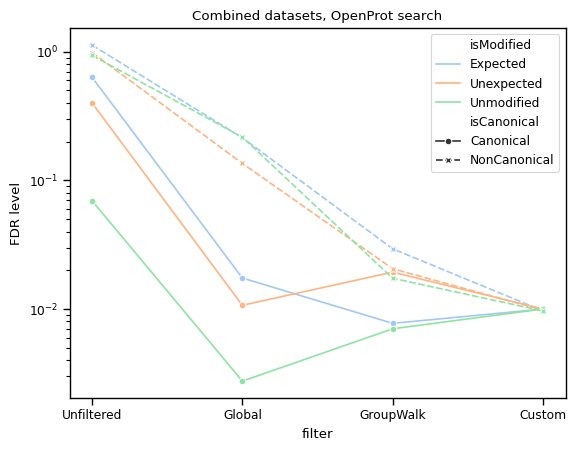

In [23]:
file_path = "./combined-FDR/openprot-group-walk-output.csv"
unfiltered         = get_FDR_df(file_path)
global_filtered    = get_FDR_df(file_path, filtering='global')
groupwalk_filtered = get_FDR_df(file_path, filtering='groupwalk')
custom_filtered    = get_FDR_df(file_path, filtering='custom')

unfiltered['filter'] = 'Unfiltered'
global_filtered['filter'] = 'Global'
groupwalk_filtered['filter'] = 'GroupWalk'
custom_filtered['filter'] = 'Custom'

data = pd.concat([unfiltered, global_filtered, groupwalk_filtered, custom_filtered], ignore_index=True)

g = sns.lineplot(data=data, y='FDR', x='filter', style='isCanonical', hue='isModified', 
                  markers=True, palette='pastel', 
                  # order=FILT_ORDER
                 )
g.set_title(f"Combined datasets, OpenProt search")
g.set_ylabel('FDR level')
g.set_yscale('log')
plt.savefig('C:/Users/pc/OneDrive - UGent/OpenProt_2/oui-discovery/publication-data/20250508-FDR-levels.svg', dpi=300, bbox_inches='tight')